# Univariate Model-Based Selection

### Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

Configuration

In [3]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
N_STEPS_IN = 5
N_STEPS_OUT = 1 # Since it is not yet Recursive DL Framework.
VAL_SIZE = 0.15
TEST_SIZE = 0.15
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

### Data Loads

In [4]:
def load_data(save_dir='data_export'):

    selected_features_path = os.path.join(save_dir, '02_results', 'selected_features.pkl')
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')

    try:
        with open(selected_features_path, 'rb') as f:
            selected_features = pickle.load(f)
        print(f"Selected features loaded")

        lag_df = pd.read_pickle(lag_path)
        print(f"Time lag dataframe loaded")

        return selected_features, lag_df
    
    except FileNotFoundError as e:
        print(f"Error in loading {e}")
        return None, None

## For the Fast running
The original code took 20+ hours for each target

### Data Prep

In [5]:
def prepare_data_unified(country_data, feature, target, n_steps_in=5):

    feature_cols = [feature]
    for i in range(1, n_steps_in):
        lag_col = f"{feature}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
    
    all_cols = feature_cols + [target] + ['year']
    data_subset = country_data[all_cols].dropna()
    
    X = data_subset[feature_cols].values
    y = data_subset[target].values.ravel()
    years = data_subset['year'].values

    # Corrected sequence due to the DL models forecasting only until 2020
    total_len = len(y)
    n_test = int(total_len * TEST_SIZE)
    n_val = int(len(y) * VAL_SIZE)
    n_train = total_len - n_test - n_val
    
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_val = X[n_train:n_train + n_val]
    y_val = y[n_train:n_train + n_val]
    X_test = X[n_train + n_val:]
    y_test = y[n_train + n_val:]
    test_years = years[n_train + n_val:]
    
    print(f"Data shapes - Train:{len(y_train)}, Val:{len(y_val)}, Test:{len(y_test)}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, test_years

### Utility Functions

In [6]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

In [7]:
# Root Mean Square Error
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [8]:
# Mean Absolute Scaled Error
def mase(y_actual, y_pred, period=1):

    mae_forecast = mean_absolute_error(y_actual, y_pred)
    
    # MAE of naive forecast
    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]
    
    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)
    
    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [9]:
# Checking stationary for ARIMA model
def check_stationarity(data, alpha=0.05):
    # P_value = result[1]
    result = adfuller(data)
    return result[1] < alpha, result[1]

In [10]:
# Making stationary if not with differencing
def make_stationary(data, max_diff=2):

    diff_order = 0
    curr_data = data.copy()

    for d in range(max_diff + 1):
        is_stationary, p_value = check_stationarity(curr_data)
        if is_stationary:
            return curr_data, d
        if d < max_diff:
            curr_data = np.diff(curr_data)
            diff_order += 1

    return curr_data, diff_order

In [11]:
# Inversing diff for differeced forecasts
def inv_diff(forecast, original_series, d):

    if d == 0:
        return forecast
    
    # Last values for inv diff
    last_values = []
    temp_series = original_series.copy()

    for i in range(d):
        last_values.append(temp_series[-1])
        if i < d - 1:
            temp_series = np.diff(temp_series)

    # Inversing
    result = forecast
    for i in range(d-1, -1, -1):
        result = np.cumsum(np.concatenate([[last_values[i]], result]))
        # Remove last_values[i]
        result = result[1:]

    return result

In [12]:
def preds_to_results(preds_data, target):

    result = {}

    feature_ = defaultdict(lambda: defaultdict(list))

    for key, data in preds_data.items():
        feature, target_name, country, model = key

        if target_name == target:
            preds = data['predictions']
            actual = data['actuals']

            rmse_score = rmse(preds, actual)
            mase_score = mase(actual, preds)

            feature_[(feature, target)][model].append({
                'country': country,
                'rmse': rmse_score,
                'mase': mase_score
            })

    for (feature, target), models in feature_.items():
        result[(feature, target)] = dict(models)

    return result

### Model builds

In [13]:
# Tuning ARIMA with AIC criterion
def tune_ARIMA_params(y_train, exog_train=None, max_p=4, max_d=2, max_q=3):
    """
    p (autoregressive order): num of lag obs to include
    d (differencing degree): num of time data different to make it stationary
    q (moving avg order): size of moving avg window
    Lower AIC -> better model fit
    """

    best_aic = np.inf
    best_params = None
    best_model = None

    # Check if it is stationary
    is_stationary, p_value = check_stationarity(y_train)

    if is_stationary:
        d_range = [0]
    else:
        _, d_needed = make_stationary(y_train, max_diff=2)
        print(f"    Not stationary p_value: {p_value:.4f}")
        d_range = [1]

    # Grid search
    for p in range(max_p + 1):
        for d in d_range:
            for q in range(max_q + 1):
                try:
                    model = ARIMA(y_train, exog=exog_train, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                
                except:
                    continue

    return best_model, best_params, best_aic

In [14]:
# Simple LSTM model
def build_lstm(input_shape, n_steps_out, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [15]:
# Bi-directional LSTM
def build_bilstm(input_shape, n_steps_out, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [16]:
# Encoder-Decoder LSTM
def build_edlstm(input_shape, n_steps_out, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(n_steps_out),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [17]:
# CNN model
def build_cnn(input_shape, n_steps_out, filters=16, hidden=8):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [18]:
def train_ARIMA_faster(X_train, y_train, X_val, y_val, X_test, y_test):
    try:
        best_aic = np.inf
        best_model = None
        best_params = None
        
        # Limited parameter ranges instead of full grid search
        param_combinations = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), (0,1,1)]
        
        for p, d, q in param_combinations:
            try:
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_model = fitted_model
            except:
                continue
        
        if best_model is None:
            return None, None, None, None
        
        print(f"    Best ARIMA: {best_params}, AIC: {best_aic:.2f}")
        
        y_trainval = np.concatenate([y_train, y_val])
        X_trainval = np.vstack([X_train, X_val])
        
        final_model = ARIMA(y_trainval, exog=X_trainval, order=best_params)
        fitted_final = final_model.fit()
        
        # Multi-step forecast
        n_forecast = len(y_test)
        preds = fitted_final.forecast(steps=n_forecast, exog=X_test)
        preds = np.array(preds).ravel()
        
        rmse_score = rmse(preds, y_test)
        mase_score = mase(y_test, preds)
        
        del fitted_final, final_model, best_model
        clear_memory()
        
        return preds, y_test, rmse_score, mase_score
        
    except Exception as e:
        print(f"    ARIMA failed: {e}")
        return None, None, None, None

In [19]:
def train_dl_faster(model_func, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    try:
        # Scale data
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
        X_train_scaled = X_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
        X_val_scaled = X_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
        X_test_scaled = X_scaler.transform(X_test)
        
        # Reshape for LSTM, CNN: (n_samples, timesteps, n_features)
        X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
        X_val_dl = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
        X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
        
        # For ED-LSTM, we need y to be (n_samples, n_steps_out, 1)
        if 'ED-LSTM' in model_name:
            y_train_dl = y_train_scaled.reshape(y_train_scaled.shape[0], N_STEPS_OUT, 1)
            y_val_dl = y_val_scaled.reshape(y_val_scaled.shape[0], N_STEPS_OUT, 1)
        else:
            y_train_dl = y_train_scaled.ravel()
            y_val_dl = y_val_scaled.ravel()
        
        # Build model
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_func(input_shape, N_STEPS_OUT)
        
        # Fast training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(
            X_train_dl, y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=min(16, len(X_train_dl)),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Predict on test set
        n_test_samples = min(len(X_test_dl), len(y_test))
        if n_test_samples > 0:
            preds_scaled = model.predict(X_test_dl[:n_test_samples], verbose=0)
            
            # Handle ED-LSTM 3D output (batch, steps, 1)
            if len(preds_scaled.shape) == 3:
                preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])
            
            # For single-step prediction, take first column if multi-step
            if len(preds_scaled.shape) == 2 and preds_scaled.shape[1] > 1:
                preds_scaled = preds_scaled[:, 0]
            elif len(preds_scaled.shape) == 2 and preds_scaled.shape[1] == 1:
                preds_scaled = preds_scaled.ravel()
            
            # Inverse transform
            preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
            actual_test = y_test[:n_test_samples]
        else:
            preds = np.array([])
            actual_test = np.array([])
        
        rmse_score = rmse(preds, actual_test) if len(preds) > 0 else np.inf
        mase_score = mase(actual_test, preds) if len(preds) > 0 else np.inf
        
        del model
        clear_memory()
        
        return preds, actual_test, rmse_score, mase_score
        
    except Exception as e:
        print(f"    {model_name} failed: {e}")
        return None, None, None, None

### Model Test

In [20]:
def test_models_faster(feature, target, lag_df):
    
    results = defaultdict(list)
    preds_data = {}
    
    for country in G20_COUNTRIES:
        country_data = lag_df[lag_df['country'] == country].sort_values('year')
        print(f"\nTesting {country}")
        
        # Unified data preparation
        data_prep = prepare_data_unified(country_data, feature, target, N_STEPS_IN)
        X_train, y_train, X_val, y_val, X_test, y_test, test_years = data_prep
        
        # Test ARIMA
        print(f"  Training ARIMA")
        arima_result = train_ARIMA_faster(X_train, y_train, X_val, y_val, X_test, y_test)
        
        if arima_result[0] is not None:
            preds, actual, rmse_score, mase_score = arima_result
            results['ARIMA'].append({
                'country': country,
                'rmse': rmse_score,
                'mase': mase_score
            })
            preds_data[(country, 'ARIMA')] = {
                'predictions': preds,
                'actuals': actual,
                'years': test_years
            }
            print(f"    ARIMA - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}")
        
        # Test DL models
        dl_models = [
            ('LSTM', build_lstm),
            ('Bi-LSTM', build_bilstm),
            ('ED-LSTM', build_edlstm),
            ('CNN', build_cnn)
        ]
        
        for model_name, model_func in dl_models:
            print(f"  Training {model_name}")
            
            dl_result = train_dl_faster(model_func, X_train, y_train, X_val, y_val, X_test, y_test, model_name)
            
            if dl_result[0] is not None:
                preds, actual, rmse_score, mase_score = dl_result
                
                results[model_name].append({
                    'country': country,
                    'rmse': rmse_score,
                    'mase': mase_score
                })
                
                preds_data[(country, model_name)] = {
                    'predictions': preds,
                    'actuals': actual,
                    'years': test_years
                }
                
                print(f"    {model_name} - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}")
    
    return results, preds_data

### Rank feature

In [21]:
def rank_features_by_country(all_results, save_dir='data_export'):
    
    country_rankings = {}
    target_rankings = {}
    
    for target in TARGET_VARIABLES:
        print(f"\nRanking features for {target}")
        target_rankings[target] = {}
        
        target_features = []
        for (feat, tgt), _ in all_results.items():
            if tgt == target:
                target_features.append(feat)
        
        # Rank features for each country
        for country in G20_COUNTRIES:
            country_scores = {}
            
            for feature in target_features:
                key = (feature, target)

                if key in all_results:
                    country_results = []

                    for model_name, model_results in all_results[key].items():
                        for result in model_results:
    
                            if result['country'] == country:
                                country_results.append(result['rmse'])
                    
                    if country_results:
                        country_scores[feature] = np.mean(country_results)
            
            # Rank features
            if country_scores:
                sorted_features = sorted(country_scores.items(), key=lambda x: x[1])
                country_rankings[(country, target)] = {
                    'feature_scores': dict(sorted_features),
                    'feature_rank_order': [f[0] for f in sorted_features]
                }
                
                print(f"\n{country} top 3 features:")
                for i, (feat, score) in enumerate(sorted_features[:3], 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        # Final ranking for all
        feature_rank_sums = defaultdict(int)
        feature_counts = defaultdict(int)
        
        for country in G20_COUNTRIES:
            key = (country, target)
            if key in country_rankings:
                rank_order = country_rankings[key]['feature_rank_order']
                for rank, feature in enumerate(rank_order, 1):
                    feature_rank_sums[feature] += rank
                    feature_counts[feature] += 1
        
        # Calculating average rank
        avg_ranks = {}
        for feature in feature_rank_sums:
            if feature_counts[feature] > 0:
                avg_ranks[feature] = feature_rank_sums[feature] / feature_counts[feature]
        
        # Final ranking
        final_ranking = sorted(avg_ranks.items(), key=lambda x: x[1])
        target_rankings[target]['final_ranking'] = final_ranking
        target_rankings[target]['avg_ranks'] = avg_ranks
        
        print(f"\nFinal feature ranking for {target}:")
        for i, (feature, avg_rank) in enumerate(final_ranking[:15], 1):
            print(f"{i}. {feature}: avg rank {avg_rank:.2f}")
    
    # Save rankings
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, 'country_uni_rankings.pkl'), 'wb') as f:
        pickle.dump(country_rankings, f)
    
    with open(os.path.join(results_dir, 'final_uni_rankings.pkl'), 'wb') as f:
        pickle.dump(target_rankings, f)
    
    return country_rankings, target_rankings

### Analysis of features

In [22]:
def run_analysis(selected_features, lag_df, target='co2', save_dir='data_export'):
    
    print(f"Analysis for {target}")
    all_results = {}
    all_preds_data = {}
    
    for feature in tqdm(selected_features):
        if feature == target:
            continue
        
        print(f"\nTesting {feature}")
        results, preds_data = test_models_faster(feature, target, lag_df)
        
        if results:
            all_results[(feature, target)] = results
            for key, value in preds_data.items():
                all_preds_data[(feature, target, key[0], key[1])] = value
    
    # Save results
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, f'{target}_predictions.pkl'), 'wb') as f:
        pickle.dump(all_preds_data, f)
    
    print(f"Results saved for {target}")
    return all_results, all_preds_data

### Summary result for the results

In [23]:
def create_summary_results(all_results, save_dir='data_export'):

    summary_data = []
    
    for (feature, target), model_results in all_results.items():
        for model_name, results_list in model_results.items():
            if results_list:
                rmse_values = [r['rmse'] for r in results_list]
                mase_values = [r['mase'] for r in results_list]
                
                summary_data.append({
                    'feature': feature,
                    'target': target,
                    'model': model_name,
                    'n_countries': len(results_list),
                    'avg_rmse': np.mean(rmse_values),
                    'std_rmse': np.std(rmse_values),
                    'min_rmse': np.min(rmse_values),
                    'max_rmse': np.max(rmse_values),
                    'avg_mase': np.mean(mase_values),
                    'std_mase': np.std(mase_values)
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    summary_df.to_csv(os.path.join(results_dir, 'uni_model_summary.csv'), index=False)
    
    return summary_df

### Overall Rank

In [56]:
# Overall rank
def overall_rank(target_rank, save_dir='data_export'):

    target_features = {}
    for target in TARGET_VARIABLES:
        if target in target_rank and 'avg_ranks' in target_rank[target]:
            target_features[target] = set(target_rank[target]['avg_ranks'].keys())
    
    if len(target_features) != len(TARGET_VARIABLES):
        print("Not all targets have rankings available")
        return None

    common_features = set.intersection(*target_features.values())

    overall_scores = {}
    feature_details = {}
    
    for feature in common_features:
        ranks = []
        rank_details = {}
        
        for target in TARGET_VARIABLES:
            rank = target_rank[target]['avg_ranks'][feature]
            ranks.append(rank)
            rank_details[target] = rank
        
        # Calculate average ranks
        overall_scores[feature] = np.mean(ranks)
        feature_details[feature] = rank_details
    
    # Sort by average rank
    overall_ranking = sorted(overall_scores.items(), key=lambda x: x[1])
    
    # Print results
    print(f"\nOverall Ranking of Features:")
    print(f"{'Rank':<4} {'Feature':<40} {'Avg_Rank':<10} {'CO2':<6} {'GDP':<6} {'Energy':<6}")
    
    for i, (feature, avg_rank) in enumerate(overall_ranking[:], 1):

        details = feature_details[feature]
        co2_rank = details.get('co2', 0)
        gdp_rank = details.get('gdp', 0)
        energy_rank = details.get('primary_energy_consumption', 0)
        print(f"{i:<4} {feature:<40} {avg_rank:<10.1f} {co2_rank:<6.1f} {gdp_rank:<6.1f} {energy_rank:<6.1f}")
    
    overall_results = {
        'ranking': overall_ranking,
        'details': feature_details,
        'common_features': list(common_features)
    }

    # Save as pickle
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, 'overall_feature_ranking.pkl'), 'wb') as f:
        pickle.dump(overall_results, f)
    
    # Save as csv
    ranking_df = pd.DataFrame([
        {
            'rank': i+1,
            'feature': feature,
            'overall_avg_rank': avg_rank,
            'co2_rank': feature_details[feature].get('co2', np.nan),
            'gdp_rank': feature_details[feature].get('gdp', np.nan),
            'energy_rank': feature_details[feature].get('primary_energy_consumption', np.nan)
        }
        for i, (feature, avg_rank) in enumerate(overall_ranking)
    ])
    
    ranking_df.to_csv(os.path.join(results_dir, 'overall_feature_ranking.csv'), index=False)
    
    return overall_results

### Visualisation

In [41]:
def plot_uni_models(country, feature, target, save_dir='data_export'):

     # Load data for the target
    pred_path = os.path.join(save_dir, '02_results', f'{target}_predictions.pkl')
    try:
        with open(pred_path, 'rb') as f:
            pred_data = pickle.load(f)
        print(f"Loaded {target}")
    except FileNotFoundError:
        print(f"Prediction file not found: {pred_path}")
        return
    
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    
    country_data = lag_df[lag_df['country'] == country].sort_values('year')
    full_years = country_data['year'].values
    full_actual = country_data[target].values

    models = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']
    available_models = []
    
    for model in models:
        key = (feature, target, country, model)
        if key in pred_data:
            available_models.append(model)
    
    if not available_models:
        print(f"No prediction data for {country}")
        return
        
    # Subplot layout
    n_models = len(available_models)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
        
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
        
    # Single subplot
    if n_models == 1:
        axes = [axes]
    elif rows == 1 and n_models > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
        
    for i, model in enumerate(available_models):
        ax = axes[i]
        key = (feature, target, country, model)
        data = pred_data[key]
        
        pred_years = data['years']
        preds = data['predictions']
        actual_test = data['actuals']

        # Same length for metrics
        min_len = min(len(pred_years), len(preds), len(actual_test))
        pred_years = pred_years[:min_len]
        predictions = preds[:min_len]
        actual_test = actual_test[:min_len]
            
        # Plot
        ax.plot(full_years, full_actual, 'b-', label='Actual', linewidth=2, alpha=0.7)
        ax.plot(pred_years, preds, 'r--', label='Predicted', linewidth=2, marker='o', markersize=2)
            
        # Calculate metrics
        if len(predictions) > 0 and len(actual_test) > 0:
            rmse_val = rmse(predictions, actual_test)
            mase_val = mase(actual_test, predictions)
        else:
            rmse_val = np.inf
            mase_val = np.inf
            
        ax.set_title(f'{model}\nRMSE: {rmse_val:.4f}, MASE: {mase_val:.4f}', fontsize=10)
        ax.legend(fontsize=8)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel(f'{target}', fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)

        # Set x-axis to show full range
        ax.set_xlim(full_years[0], full_years[-1])
        
    plt.suptitle(f'{country}: {feature} - {target}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    plots_dir = os.path.join(save_dir, '02_plots', '03_univariate_models')
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    filename = os.path.join(plots_dir, f'uni_{country}_{feature}_to_{target}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [26]:
selected_features, lag_df = load_data()

Selected features loaded
Time lag dataframe loaded


In [ ]:
co2_results, co2_preds = run_analysis(selected_features, lag_df, target='co2')

In [ ]:
gdp_results, gdp_preds = run_analysis(selected_features, lag_df, target='gdp')

In [ ]:
energy_results, energy_preds = run_analysis(selected_features, lag_df, target='primary_energy_consumption')

In [44]:
all_combined_results = {}

with open(f"data_export/02_results/co2_predictions.pkl", 'rb') as f:
    co2_preds = pickle.load(f)

co2_results = preds_to_results(co2_preds, 'co2')

with open(f"data_export/02_results/gdp_predictions.pkl", 'rb') as f:
    gdp_preds = pickle.load(f)

gdp_results = preds_to_results(gdp_preds, 'gdp')

with open(f"data_export/02_results/primary_energy_consumption_predictions.pkl", 'rb') as f:
    energy_preds = pickle.load(f)

energy_results = preds_to_results(energy_preds, 'primary_energy_consumption')

In [45]:
all_combined_results.update(co2_results)
all_combined_results.update(gdp_results) 
all_combined_results.update(energy_results)

country_rankings, final_rankings = rank_features_by_country(all_combined_results)

summary_df = create_summary_results(all_combined_results)


Ranking features for co2

United States top 3 features:
  1. energy_cons_change_pct: 202.8863
  2. co2_growth_prct: 221.7002
  3. gas_cons_change_pct: 263.2276

China top 3 features:
  1. coal_consumption: 1298.6001
  2. fossil_fuel_consumption: 1537.4255
  3. electricity_generation: 1855.1238

Japan top 3 features:
  1. energy_per_capita: 63.9861
  2. fossil_fuel_consumption: 74.5093
  3. oil_cons_change_pct: 99.4214

Germany top 3 features:
  1. low_carbon_consumption: 63.8098
  2. energy_per_gdp: 64.8269
  3. coal_consumption: 71.9336

United Kingdom top 3 features:
  1. population: 88.2055
  2. co2_per_unit_energy: 91.7352
  3. energy_per_capita: 103.2365

France top 3 features:
  1. energy_per_gdp: 27.5461
  2. coal_consumption: 41.8293
  3. population: 45.2139

Italy top 3 features:
  1. fossil_fuel_consumption: 33.5860
  2. energy_per_capita: 38.3804
  3. oil_consumption: 44.0649

Canada top 3 features:
  1. oil_consumption: 17.6954
  2. hydro_consumption: 18.2029
  3. fossil_f

In [57]:
overall_ranking = overall_rank(final_rankings)


Overall Ranking of Features:
Rank Feature                                  Avg_Rank   CO2    GDP    Energy
1    fossil_fuel_consumption                  5.1        3.8    7.1    4.3   
2    electricity_generation                   5.6        7.7    3.7    5.5   
3    energy_per_capita                        6.8        6.2    9.5    4.7   
4    oil_consumption                          7.5        7.0    8.7    6.7   
5    population                               7.8        8.9    5.8    8.7   
6    gas_consumption                          8.5        10.1   6.4    8.9   
7    coal_consumption                         9.1        8.4    7.9    11.1  
8    co2_per_unit_energy                      10.7       9.3    11.5   11.2  
9    nuclear_consumption                      11.0       12.1   10.6   10.3  
10   hydro_consumption                        11.3       11.2   11.9   10.7  
11   energy_cons_change_pct                   11.5       10.9   12.3   11.3  
12   gas_cons_change_pct          

* Fossil

    fossil_fuel_consumption (1) = oil + gas + coal

    - oil_consumption (4)

    - gas_consumption (6)

    - coal_consumption (7)


* intensity

energy_per_capita (3)

co2_per_unit_energy (8)

energy_per_gdp (15)


* Production

electricity_generation (2)

* Demographic feature

population (5)

* low_carbon

    low_carbon_consumption (14) = renewable + nuclear

    - renewables_consumption = hydro + wind + solar + other

    - nuclear_consumption (9)

    - hydro_consumption (10)

* Removing all Growth and Change

Loaded co2


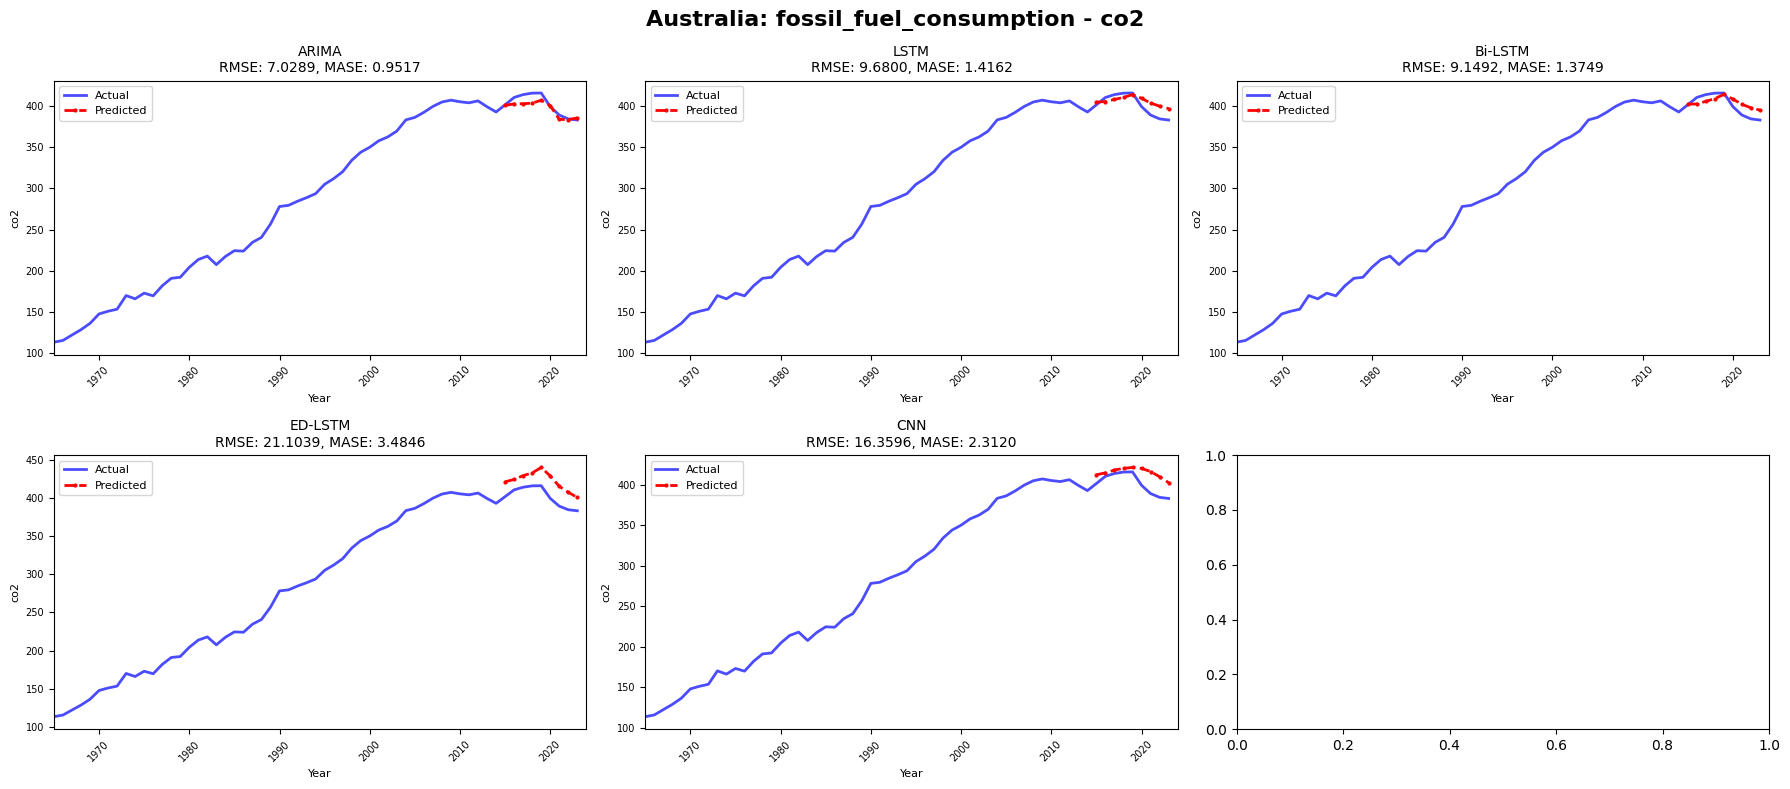

In [48]:
plot_uni_models(country='Australia', feature='fossil_fuel_consumption', target='co2')

Loaded gdp


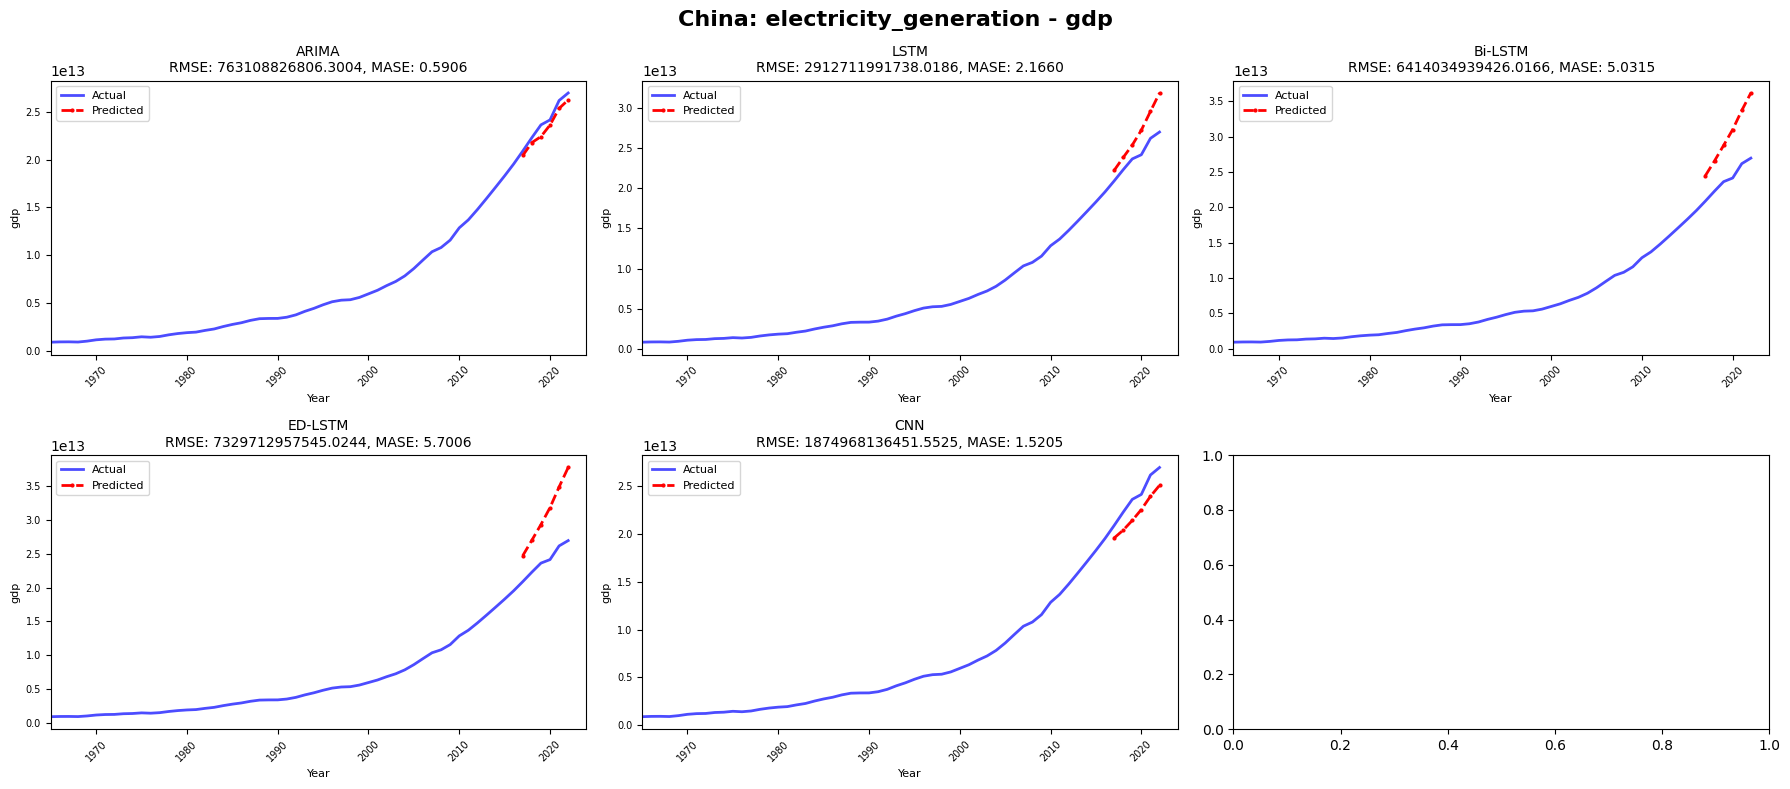

In [52]:
plot_uni_models('China', 'electricity_generation', 'gdp')

Loaded primary_energy_consumption


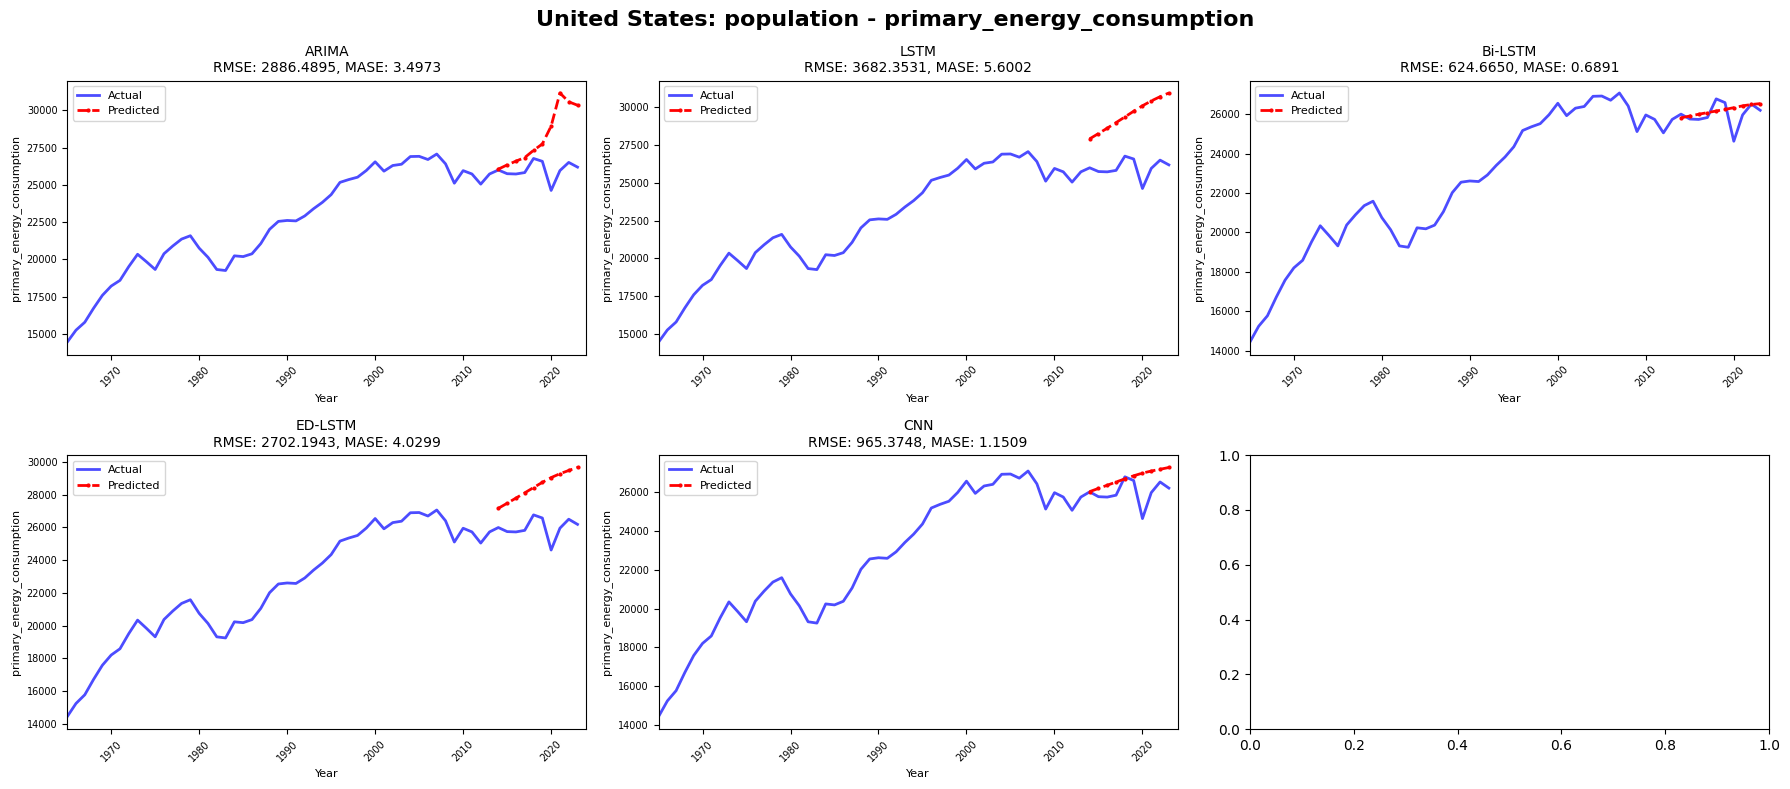

In [53]:
plot_uni_models('United States', 'population', 'primary_energy_consumption')